L’objectif de ce notebook est d’étudier l’algorithme A2C (Advantage Actor-Critic)
sur l’environnement BipedalWalker-v3.

Nous analysons :
- une version de base de A2C, utilisant des hyperparamètres standards ;
- une version améliorée, obtenue par ajustement des hyperparamètres,

afin d’évaluer l’impact du tuning sur les performances, la stabilité et
le coût computationnel.

Les résultats seront ensuite comparés à ceux obtenus avec PPO.

In [7]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

BipedalWalker-v3 est un environnement de contrôle continu dans lequel
un robot bipède doit apprendre à marcher sans tomber.

- Observations : état continu décrivant la posture, les vitesses et les contacts
- Actions : 4 actions continues contrôlant les moteurs des jambes
- Récompense : progression vers l’avant avec pénalités (énergie, chutes)
- Objectif : maximiser la récompense cumulée par épisode

Cet environnement est particulièrement difficile pour A2C en raison :
- de la forte variance des trajectoires
- du caractère continu des actions
- de la sensibilité aux hyperparamètres

In [8]:
ENV_ID = "BipedalWalker-v3"

def make_env(seed=0):
    env = gym.make(ENV_ID)
    env.reset(seed=seed)
    env = Monitor(env)
    return env

# Vérification
env = make_env(0)
print(env.observation_space)
print(env.action_space)
env.close()

Box([-3.1415927 -5.        -5.        -5.        -3.1415927 -5.
 -3.1415927 -5.        -0.        -3.1415927 -5.        -3.1415927
 -5.        -0.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.       ], [3.1415927 5.        5.        5.        3.1415927 5.        3.1415927
 5.        5.        3.1415927 5.        3.1415927 5.        5.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.       ], (24,), float32)
Box(-1.0, 1.0, (4,), float32)


Dans cette section, nous entraînons un agent A2C avec des hyperparamètres
classiques.

Cette version sert de référence afin :
- d’observer la dynamique d’apprentissage initiale de A2C
- d’identifier ses limites sur un environnement complexe

In [9]:
TIMESTEPS = 500_000
SEED = 0

env = make_env(SEED)

model_a2c = A2C(
    "MlpPolicy",
    env,
    learning_rate=7e-4,
    n_steps=5,
    gamma=0.99,
    gae_lambda=1.0,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=0,
    seed=SEED
)

Ces hyperparamètres correspondent à une configuration standard de A2C :
- n_steps faible → mises à jour fréquentes mais bruitées
- gae_lambda = 1 → A2C sans réduction de variance
- ent_coef > 0 → exploration encouragée

In [10]:
start = time.time()
model_a2c.learn(total_timesteps=TIMESTEPS)
time_a2c = time.time() - start

a2c_rewards = env.get_episode_rewards()
env.close()

print("A2C training time (s):", round(time_a2c, 2))

A2C training time (s): 2434.42


In [11]:
# Évaluation
env = make_env(123)
a2c_mean, a2c_std = evaluate_policy(
    model_a2c, env,
    n_eval_episodes=20,
    deterministic=True
)
env.close()

print("A2C mean reward:", a2c_mean)
print("A2C std:", a2c_std)

A2C mean reward: -74.46003115
A2C std: 85.27549359798718


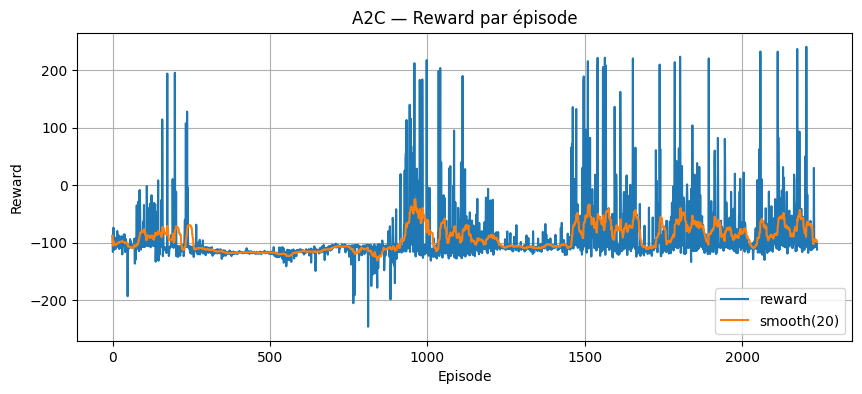

In [12]:
# courbe d'apprentissage
r = np.array(a2c_rewards)
smooth = pd.Series(r).rolling(20, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(r, label="reward")
plt.plot(smooth, label="smooth(20)")
plt.title("A2C — Reward par épisode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

L’agent A2C apprend parfois rapidement au début,
mais montre une forte instabilité :

- chutes fréquentes du robot
- grande variance entre les épisodes
- performance finale limitée

Cette instabilité est liée à :
- la faible taille des rollouts
- l’absence de mécanisme de clipping (contrairement à PPO)

#### A2C améliorée

L’objectif de cette section est de réduire la variance de l’apprentissage
et d’améliorer la stabilité de la politique apprise par A2C.

Nous cherchons à :
- lisser les gradients
- stabiliser l’estimation des avantages
- limiter les mises à jour trop agressives

In [13]:
TIMESTEPS_IMPROVED = 1_000_000
SEED_IMPROVED = 0

A2C_IMPROVED_PARAMS = dict(
    learning_rate=3e-4,
    n_steps=10,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.005,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=0,
    seed=SEED_IMPROVED
)

print("A2C improved params:", A2C_IMPROVED_PARAMS)

A2C improved params: {'learning_rate': 0.0003, 'n_steps': 10, 'gamma': 0.99, 'gae_lambda': 0.95, 'ent_coef': 0.005, 'vf_coef': 0.5, 'max_grad_norm': 0.5, 'verbose': 0, 'seed': 0}


Améliorations apportées :
- learning_rate réduit → updates plus stables
- n_steps augmenté → meilleure estimation des gradients
- GAE activé → réduction de la variance
- ent_coef réduit → exploration plus contrôlée

In [14]:
# entrainement avec les nouveaux hyperparamètres
env = make_env(SEED_IMPROVED)

model_a2c_improved = A2C(
    "MlpPolicy",
    env,
    **A2C_IMPROVED_PARAMS
)

start = time.time()
model_a2c_improved.learn(total_timesteps=TIMESTEPS_IMPROVED)
time_a2c_improved = time.time() - start

a2c_improved_rewards = env.get_episode_rewards()
env.close()


In [15]:
# évaluation (a2c amélioré)
env = make_env(123)
a2c_improved_mean, a2c_improved_std = evaluate_policy(
    model_a2c_improved, env,
    n_eval_episodes=50,
    deterministic=True
)
env.close()

print("A2C improved mean reward:", a2c_improved_mean)
print("A2C improved std:", a2c_improved_std)

A2C improved mean reward: -116.78456812
A2C improved std: 3.966507908394035


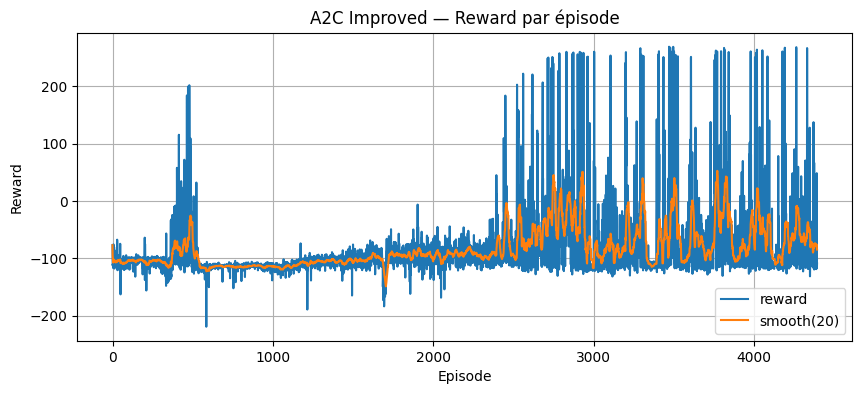

In [16]:
# courbe d'apprentissage (a2c amélioré)
r = np.array(a2c_improved_rewards)
smooth = pd.Series(r).rolling(20, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(r, label="reward")
plt.plot(smooth, label="smooth(20)")
plt.title("A2C Improved — Reward par épisode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()


## Analyse - A2C amélioré

La version améliorée d’A2C montre :
- une progression plus régulière
- une réduction de la variance
- une meilleure robustesse que la version de base

Cependant, malgré ces améliorations, A2C reste :
- moins stable que PPO
- plus sensible au bruit de l’environnement
- limité en performance finale sur BipedalWalker


In [17]:
# Comparaison des deux versions
compare_a2c = pd.DataFrame([
    {"Version": "A2C (base)", "Mean": a2c_mean, "Std": a2c_std, "Train time (s)": time_a2c},
    {"Version": "A2C improved", "Mean": float(a2c_improved_mean), "Std": float(a2c_improved_std), "Train time (s)": time_a2c_improved},
])
compare_a2c


,Version,Mean,Std,Train time (s)
0,A2C (base),-74.460031,85.275494,2434.424846
1,A2C improved,-116.784568,3.966508,2245.816760


A2C est plus simple que PPO mais souffre d’une plus grande variance.
Même avec un tuning soigné, PPO reste plus stable et plus performant
sur des environnements continus complexes comme BipedalWalker.